In [1]:
import pandas

dataset = pandas.read_table("ICPSR_37692/DS0001/37692-0001-Data.tsv", low_memory=False)
# dataset.drop_duplicates() -- Removed because there are no duplicate values.

In [2]:
def remove_indet(frame, variable_name, keep_dontknow=False, dontknow_signal="-1"):
    ''' 
    Removes entries from the dataframe for which the given variables has a negative, indeterminate value.
    When keep_dontknow is true, it preserves entries for which the value was "-1", which is used in the data as a generic
    "don't know" signal. That operation does not preserve order.
    '''
    neg_mask = frame[variable_name].str[0] == "-"
    if keep_dontknow:
        frame1 = frame.query('not @neg_mask')
        frame2 = frame.query(f'{variable_name} == "{dontknow_signal}"')
        frame = pandas.concat([frame1, frame2])
    else:
        frame = frame.query('not @neg_mask')
        
    frame = frame.query(f"{variable_name} != ' '")

    return frame
    

First, we will cut the data into sets for specific groups of interest.

In [3]:
'''Select only self-identified transgender people.'''

trans_data = dataset.query('V1212 == "3"')

In [4]:
'''
Select only data on non-straight people. This excludes V1213 answer 2, 
and also people who failed to indicate sexual orientation.

I include people who reported that they did not know their sexual orientation,
either via the -1 "Don't Know" error coding or the 5 "You don't know the answer."
This should allow for questioning people to be included as well.
'''

lgbq_data = dataset.query('V1213 != "2"') 
lgbq_data = remove_indet(lgbq_data, "V1213", keep_dontknow=True)

In [5]:
'''
Select agnc (assigned gender non-conforming) people. I define this to mean people whose assigned sex at birth does not match
their gender, regardless of transgender identification.
'''

agnc_data = dataset.query('V1211 != V1212')
agnc_data = remove_indet(agnc_data, 'V1211')
agnc_data = remove_indet(agnc_data, 'V1212', keep_dontknow=True)

In [6]:
'''
It will be handy to have a set of "non-LGBTQ" people: cis straight people. We'll prefix that cs. 
'''

cis_data = dataset.query('V1211 == V1212')
cis_data = remove_indet(cis_data, 'V1212')
cs_data = cis_data.query('V1213 == "2"')

In [7]:
print(len(dataset))
print(len(trans_data))
print(len(lgbq_data))
print(len(agnc_data))
print(len(cs_data))

24848
31
1985
94
22653


In [8]:
''' Interestingly, only about 1 in 3 ASNC people in this population chose to label themselves transgender. '''
len(trans_data)/len(agnc_data)

0.32978723404255317

In [9]:
''' Merge into a dataset for all lgbtq people. '''
lgbtq_data = pandas.concat([lgbq_data, agnc_data]).drop_duplicates()
len(lgbtq_data)

2015

In [10]:
''' Total LGBTQ rate was 8.7%, markedly higher than the US rate (~3.7%). '''
len(lgbtq_data) / len(dataset)

0.08109304571796523

In [11]:
''' 
71% of LGBTQ respondants identified as female, but only 
25% of the total population did. 
'''

m = len(lgbtq_data.query("V1212 == '1'"))
f = len(lgbtq_data.query("V1212 == '2'"))
print(f / (m+f))

m = len(dataset.query("V1212 == '1'"))
f = len(dataset.query("V1212 == '2'"))
print(f / (m+f))

0.7144314125446201
0.2530443253774963


Seperate these datasets by state.

In [12]:
''' Read in data needed for the ORR '''

state_lgbt = pandas.read_csv("pop_counts/lbgt_percent_by_state.csv")

state_incs = pandas.read_csv("pop_counts/total_incarcerated_by_state.csv")

In [13]:
''' A list of all state codes present in the dataset. Invalid codes are removed. '''
list_state_codes = ['FL', 'MD', 'PA', 'NM', 'KY', 'MA', 'OR', 'WV', 'WI', 'WA', 'MI', 'CA', 'IL', 'VA', 'DE', 'NY', 'NV', 'SD', 'LA', 'UT', 'TX', 'MN', 'MO', 'SC', 'GA', 'NC', 'TN', 'IA', 'OH', 'IN', 'CT', 'MS', 'AR', 'HI', 'OK', 'NJ', 'ID', 'AZ', 'VT', 'NE', 'CO', 'AK', 'AL', 'KS', 'ND', 'RI', 'NH', 'WY', 'MT', 'ME']
# PR, DC removed because other datasets exclude them. Too bad!

In [14]:
''' 
Remove states with too few responses. 
For now I'll say that a state has too few responses when each contributes
more than 1% of the total, i.e. when there are fewer than 100 responses,
or when their response ratio is less than 0.25%
'''

true_list_state_codes = []

print("Removing states with n < 100 or rr < 0.0025:")
for state in list_state_codes:
    N = len(dataset.query(f"V0772 == '{state}'")) 
    I = int(state_incs.query(f'State == "{state}"')['Incarcerated'])
    if N < 100 or (N/I) < 0.0025:
        print(state)
    else:
        true_list_state_codes.append(state)

list_state_codes = true_list_state_codes
print(f"There are {len(list_state_codes)} states left in the sample.")


Removing states with n < 100 or rr < 0.0025:
KY
WA
DE
UT
MN
NJ
ID
VT
CO
ND
RI
NH
WY
MT
ME
There are 35 states left in the sample.


In [15]:
def cut_by_state(frame):
    ''' Divide a dataframe into a dictionary of dataframes by state the inmate was living in at the time of arrest. '''
    statewise_dict = {}
    for state in list_state_codes:
        subset = frame.query(f'V0772 == "{state}"')
        statewise_dict[state] = subset
        
    return statewise_dict
        

In [16]:
lgbtq_bs = cut_by_state(lgbtq_data)

In [17]:
''' Count responses after pruning. '''
s = 0
ls = 0
for state in list_state_codes:
    s += len(dataset.query(f'V0772 == "{state}"'))
    ls += len(lgbtq_bs[state])

print(s)
print(ls)
    

22760
1805


# OVERREPRESENTATION

Calculate the LGBTQ overrepresentation index for each state.

The OverRepresentation Ratio is meant to measure how much more likely an LGBTQ person is to be incarcerated in a given
state than a member of the general population. It's made of the following factors:

In [18]:
'''
OverRepresentation Ratio, measures proportion of 
LGBTQ prisoners in sample to ordinary prisoners.

Note that these values are unweighted, and so must be used with care. 

a - number self-reported lgbtq people in sample in state
N - number sampled in state
L - estimated proportion lgbtq in state

o = (a/N) / L

'''
vars_bs = {}

for state in list_state_codes:
    a = len(lgbtq_bs[state])
    L = float(state_lgbt.query(f'State == "{state}"')['Estimated Percent LGBT']) / 100
    I = int(state_incs.query(f'State == "{state}"')['Incarcerated'])
    N = len(dataset.query(f'V0772 == "{state}"'))
    vars_bs[f'{state}'] = [(a/N), L, ((a/N) / L),(N/I)]

In [19]:
rep_plot_frame = pandas.DataFrame.from_dict(vars_bs, orient='index', columns = ['incar_lgbtq', 'state_lgbtq', 'orr', 'rratio'])

<AxesSubplot:>

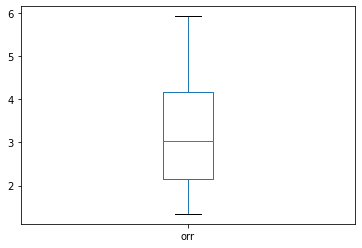

In [20]:
rep_plot_frame['orr'].plot.box()

<AxesSubplot:xlabel='state_lgbtq', ylabel='incar_lgbtq'>

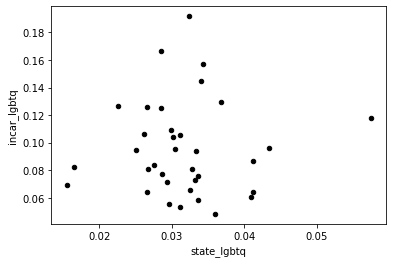

In [21]:
''' There's no obvious pattern except a cluster near the lower area. Actually, that's odd. '''
rep_plot_frame.plot.scatter(x='state_lgbtq', y='incar_lgbtq', c='black')

In [22]:
print(rep_plot_frame.sort_values('orr',axis='index', ascending=False))
print("\nMedians:")
print(rep_plot_frame.median())
print("\nMeans:")
print(rep_plot_frame.mean())

    incar_lgbtq  state_lgbtq       orr    rratio
WV     0.191617     0.032366  5.920297  0.008308
NE     0.166667     0.028438  5.860606  0.004378
SD     0.126667     0.022599  5.605000  0.010000
AR     0.082418     0.016567  4.974725  0.005049
SC     0.126050     0.026607  4.737472  0.006919
NM     0.157360     0.034335  4.583122  0.006523
AK     0.069620     0.015501  4.491422  0.012248
OK     0.125000     0.028557  4.377212  0.004617
IN     0.144404     0.034017  4.245109  0.003465
WI     0.106695     0.026108  4.086682  0.004756
KS     0.094972     0.025060  3.789776  0.004649
LA     0.109533     0.029899  3.663461  0.004441
HI     0.129464     0.036723  3.525412  0.008145
VA     0.104403     0.030108  3.467626  0.006625
CT     0.105442     0.031136  3.386499  0.004933
NC     0.095178     0.030416  3.129227  0.005278
IA     0.084211     0.027575  3.053842  0.004069
TN     0.080935     0.026651  3.036851  0.004657
OH     0.094106     0.033279  2.827790  0.003225
AL     0.077482     

For comparison, I'll do the same steps to calculate an ORR for the African American community (AAORR).

In [23]:
''' Read in race proportion estimates from each state. '''

state_racial = pandas.read_csv("pop_counts/race_by_state.csv")

In [24]:
aa_data = dataset.query('V1953 == 1')
print(len(aa_data))
aa_bs = cut_by_state(aa_data)

9403


In [25]:
aa_vars_bs = {}

for state in list_state_codes:
    aa = len(aa_bs[state])
    AA = float(state_racial.query(f'Label == "{state}"')['Black or African American'])
    I = int(state_incs.query(f'State == "{state}"')['Incarcerated'])
    N = len(dataset.query(f'V0772 == "{state}"'))
    aa_vars_bs[f'{state}'] = [(aa/N), AA, ((aa/N) / AA), (N/I)]
    
aa_rep_plot_frame = pandas.DataFrame.from_dict(aa_vars_bs, orient='index', columns = ['incar', 'general', 'aaorr', 'rratio'])

<AxesSubplot:>

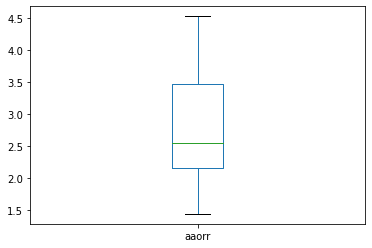

In [26]:
aa_rep_plot_frame['aaorr'].plot.box()

<AxesSubplot:xlabel='general', ylabel='incar'>

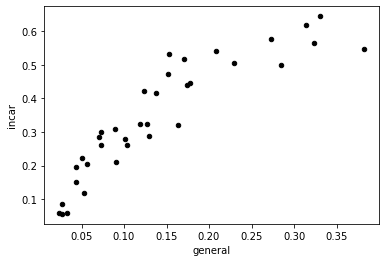

In [27]:
''' There is a clear positive correlation between general AA population and AA prison overrepresentation. '''
aa_rep_plot_frame.plot.scatter(x='general', y='incar', c='black')

In [28]:
#print(aa_rep_plot_frame.sort_values('aaorr',axis='index', ascending=False))
print("\nMedians:")
print(aa_rep_plot_frame.median())
print("\nMeans:")
print(aa_rep_plot_frame.mean())


Medians:
incar      0.321429
general    0.123000
aaorr      2.552087
rratio     0.004657
dtype: float64

Means:
incar      0.344648
general    0.140857
aaorr      2.768328
rratio     0.006001
dtype: float64


Let's try with "non-white" in general also.

In [29]:
nw_data = dataset.query('V1952 != 1')
print(len(nw_data))
nw_bs = cut_by_state(nw_data)

12817


In [30]:
nw_vars_bs = {}

for state in list_state_codes:
    nw = len(nw_bs[state])
    NW = 1 - float(state_racial.query(f'Label == "{state}"')['White'])
    I = int(state_incs.query(f'State == "{state}"')['Incarcerated'])
    N = len(dataset.query(f'V0772 == "{state}"'))
    nw_vars_bs[f'{state}'] = [(nw/N), NW, ((nw/N) / NW), (N/I)]
    
nw_rep_plot_frame = pandas.DataFrame.from_dict(nw_vars_bs, orient='index', columns = ['incar', 'general', 'nworr', 'rratio'])

<AxesSubplot:>

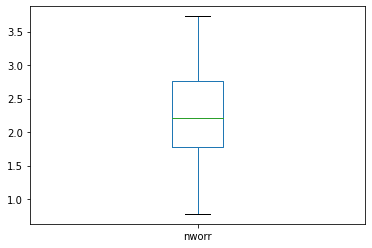

In [31]:
nw_rep_plot_frame['nworr'].plot.box()

<AxesSubplot:xlabel='general', ylabel='incar'>

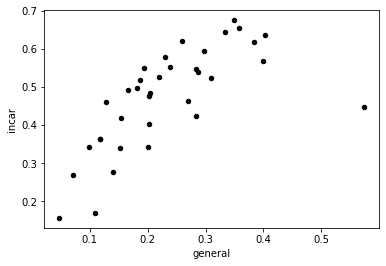

In [32]:
''' 
There is a clear positive correlation between general non-white population and non-white prison overrepresentation.
Hawaii is an outlier, probably due to the native pacific islander population.
'''

nw_rep_plot_frame.plot.scatter(x='general', y='incar', c='black')

In [33]:
#print(nw_rep_plot_frame.sort_values('nworr',axis='index', ascending=False))
print("\nMedians:")
print(nw_rep_plot_frame.median())
print("\nMeans:")
print(nw_rep_plot_frame.mean())


Medians:
incar      0.491717
general    0.205000
nworr      2.212389
rratio     0.004657
dtype: float64

Means:
incar      0.472013
general    0.233143
nworr      2.276673
rratio     0.006001
dtype: float64


I will next check the gender disparity between the LGBTQ and non-LGBTQ prison populations. Evidently, it's quite large, but let's look at it by state. Note: we are *NOT* checking against the general state populations in this step.

In [34]:
cs_bs = cut_by_state(cs_data)

In [35]:
gd_vars_bs = {}

for state in list_state_codes:
    csf = len(cs_bs[state].query("V1212 == '2'")) / len(cs_bs[state])
    qf = len(lgbtq_bs[state].query('V1212 == "2"')) / len(lgbtq_bs[state])
    f = len(dataset.query(f'V0772 == "{state}"').query('V1212 == "2"')) / len(dataset.query(f'V0772 == "{state}"'))
    gd_vars_bs[state] = [f, csf, qf]
    
gd_plot_frame = pandas.DataFrame.from_dict(gd_vars_bs, orient='index', columns = ['fem_prop', 'cs_fem_prop', 'lgbtq_fem_prop'])

<AxesSubplot:>

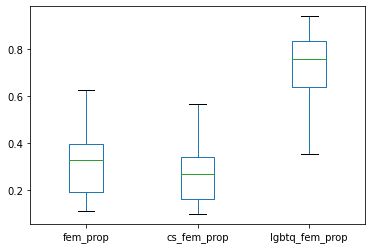

In [36]:
''' Across the board, more of the LGBTQ prison population is female than the cis straight prison population. '''
gd_plot_frame.plot.box()

<AxesSubplot:xlabel='cs_fem_prop', ylabel='lgbtq_fem_prop'>

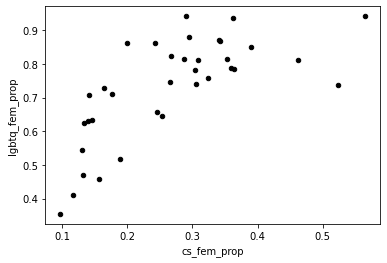

In [37]:
''' Unsurprisingly, prisons with more cis straight females have more lgbtq females also. '''
gd_plot_frame.plot.scatter(x='cs_fem_prop', y='lgbtq_fem_prop', c='black')

In [38]:
'''
Combine the frames so far to allow for more interesting comparisons.
'''

prime_plot_frame = gd_plot_frame.join(rep_plot_frame, how="left").join(aa_rep_plot_frame['aaorr'], how="left").join(nw_rep_plot_frame['nworr'], how="left")

<AxesSubplot:xlabel='orr', ylabel='fem_prop'>

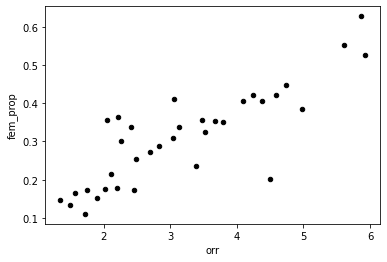

In [39]:
'''
One can observe a positive correlation between the proportion of 
female inmates and the ORR.
'''
prime_plot_frame.plot.scatter(x="orr", y="fem_prop", color="black")

<AxesSubplot:xlabel='orr', ylabel='nworr'>

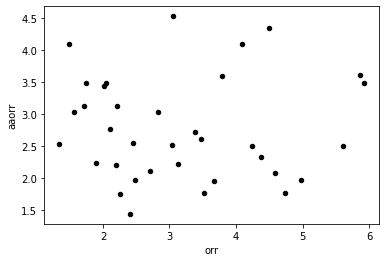

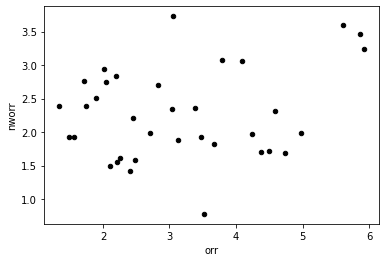

In [40]:
''' 
There is no clear correlation between the aaorr or nworr and the lgbtq orr.
This is further evidence that the two phenomena are fairly distinct.
'''

prime_plot_frame.plot.scatter(x="orr", y="aaorr", color="black")
prime_plot_frame.plot.scatter(x="orr", y="nworr", color="black")

<AxesSubplot:xlabel='rratio', ylabel='lgbtq_fem_prop'>

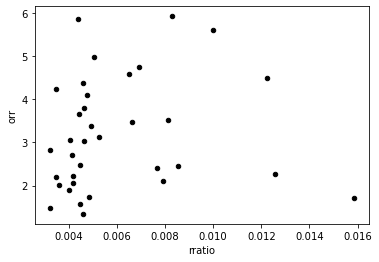

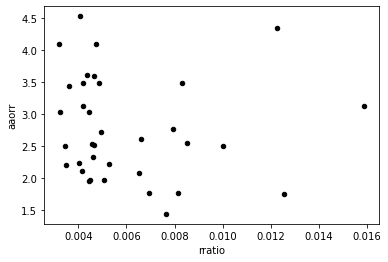

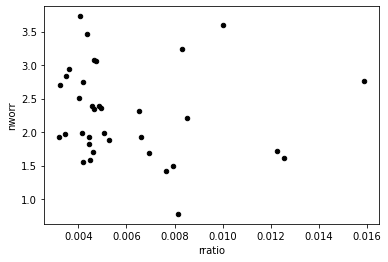

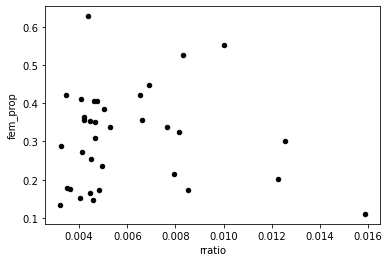

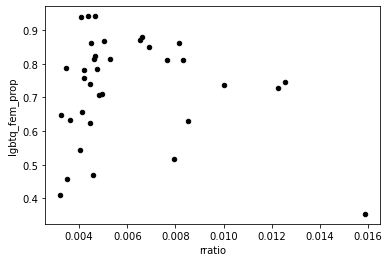

In [41]:
'''
None of these measures seem too influenced by response ratio.
'''

prime_plot_frame.plot.scatter(x="rratio", y="orr", c='black')
prime_plot_frame.plot.scatter(x="rratio", y="aaorr", c='black')
prime_plot_frame.plot.scatter(x="rratio", y="nworr", c='black')
prime_plot_frame.plot.scatter(x="rratio", y="fem_prop", c='black')
prime_plot_frame.plot.scatter(x="rratio", y="lgbtq_fem_prop", c='black')

# EXPERIENCE

I'll make a few helper functions.

In [42]:
def variable_compare_LGBTQ(query_str, trait_name):
    '''Compares a given variable between LGBTQ and cis-straight prisoners, 
    returning a dataframe with which to plot that and making a box plot.'''
    
    plot_vars_bs = {}
    count = 0
    for state in list_state_codes:
        c = len(cs_bs[state].query(query_str)) / len(cs_bs[state])
        q = len(lgbtq_bs[state].query(query_str)) / len(lgbtq_bs[state])
        plot_vars_bs[state] = [c, q]
        count += 1
    
    var_plot_frame = pandas.DataFrame.from_dict(plot_vars_bs, orient='index', columns = ['cs_' + trait_name, 'lgbtq_' + trait_name])
    if count > 0:
        var_plot_frame.plot.box()
    return var_plot_frame

In [43]:
import statistics as stat
def five_point_rate(var_name, trait_name):
    ''' Like variable_compare_lgbtq, but the value is instead the mean 
    response value given on 5 point scale. Fails if the variable
    is not in a 5 point scale. '''
    
    plot_vars_bs = {}
    c = 0
    q = 0
    
    for state in list_state_codes:
        for i in range(1, 6):
            c += len(cs_bs[state].query(f"{var_name} == '{i}'")) * i
            q += len(lgbtq_bs[state].query(f"{var_name} == '{i}'")) * i
        c /= len(cs_bs[state])
        q /= len(lgbtq_bs[state])
        plot_vars_bs[state] = [6-c, 6-q] # Higher values now measure more of given thing.
    var_plot_frame = pandas.DataFrame.from_dict(plot_vars_bs, orient='index', columns = ['cs_' + trait_name, 'lgbtq_' + trait_name])
    var_plot_frame.plot.box()
    return var_plot_frame

Time to start measuring the treatment/experience side of things.

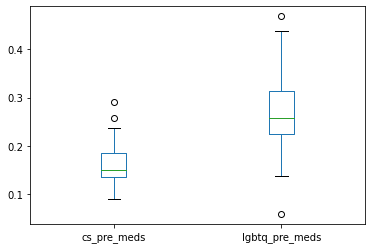

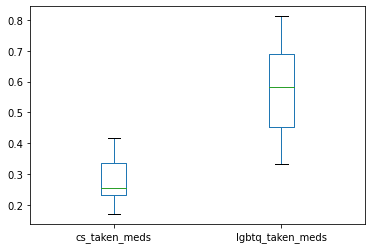

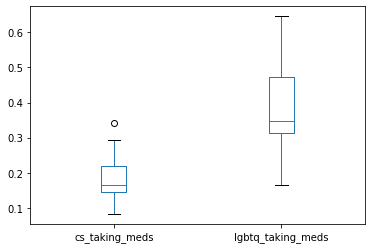

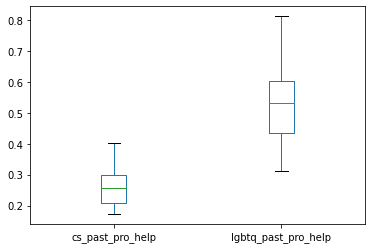

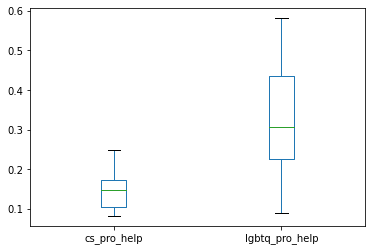

In [44]:
pre_meds_plot_frame = variable_compare_LGBTQ("V1201 == '1'", "pre_meds")
past_meds_plot_frame = variable_compare_LGBTQ("V1202 == '1'", "taken_meds")
meds_plot_frame = variable_compare_LGBTQ("V1203 == '1'", "taking_meds")
past_pro_help_plot_frame = variable_compare_LGBTQ("V1204 == '1'", "past_pro_help")
pro_help_plot_frame = variable_compare_LGBTQ("V1205 == '1'", "pro_help")


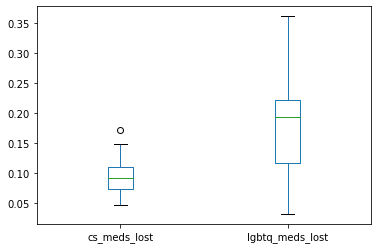

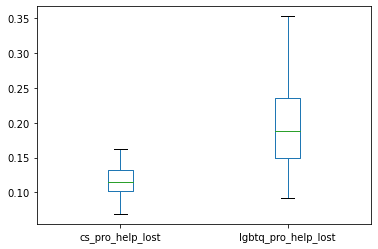

In [45]:
''' LGBTQ people lose access to medication and professional help at a higher rate than cs people. '''
meds_lost_plot_frame = variable_compare_LGBTQ("V1202 == '1' and V1203 == '2'", "meds_lost")
pro_help_lost_plot_frame = variable_compare_LGBTQ("V1204 == '1' and V1205 == '2'", "pro_help_lost")

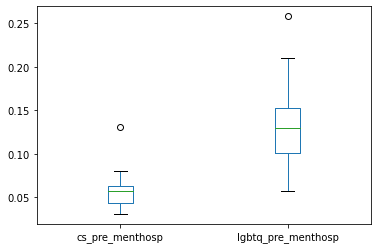

In [46]:
''' LGBTQ inmates are far more likely to have been hospitalized due to mental health than cs inmates. '''
pre_menthosp_plot_frame = variable_compare_LGBTQ("V1200 == '1'", "pre_menthosp")

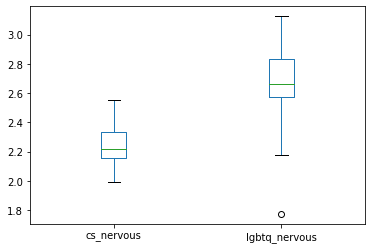

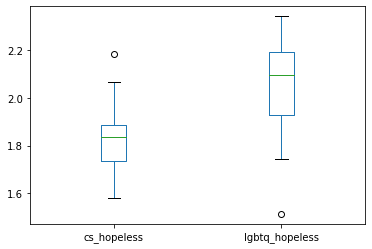

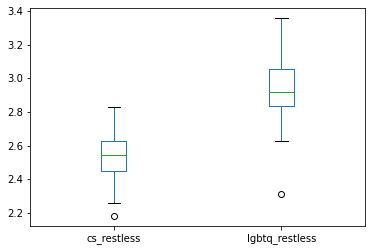

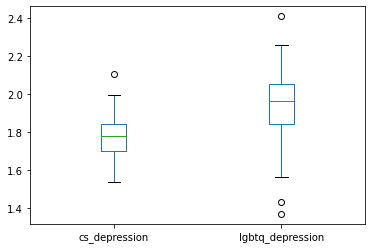

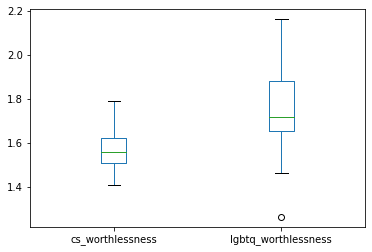

In [47]:
''' LGBTQ people rank higher on all mh scores. '''
mh_plot_frame = five_point_rate("V1179", "nervous")
mh_plot_frame = mh_plot_frame.join(five_point_rate("V1180", "hopeless"))
mh_plot_frame = mh_plot_frame.join(five_point_rate("V1181", "restless"))
mh_plot_frame = mh_plot_frame.join(five_point_rate("V1182", "depression"))
mh_plot_frame = mh_plot_frame.join(five_point_rate("V1184", "worthlessness"))

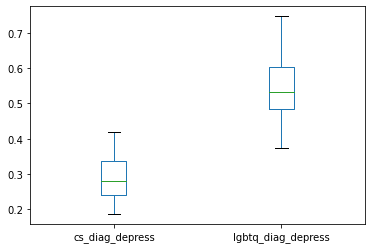

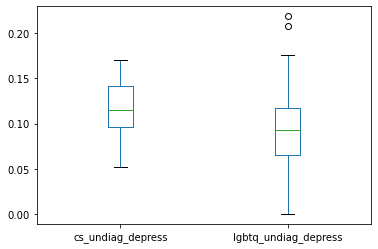

In [48]:
''' LGBTQ inmates are more likely to be diagnosed with depression, to the point that in most states, 
they are less likely then cs inmates to express depressive symptoms without being diagnosed. '''
diag_depress_plot_frame = variable_compare_LGBTQ("V1186 == '1'", 'diag_depress')
undiag_depress_plot_frame = variable_compare_LGBTQ("(V1182 == '3' or V1182 == '2' or V1182 == '1') and V1186 == '2'", 'undiag_depress')

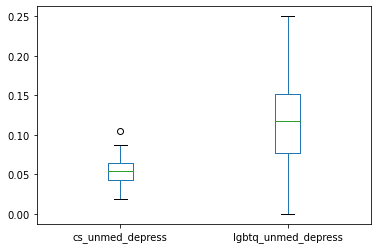

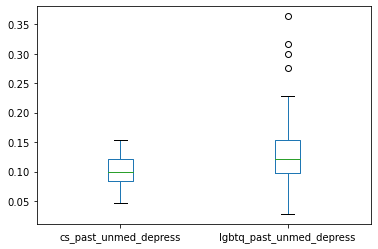

In [49]:
''' LGBTQ inmates are far more likely to be diagnosed with depression yet not have received/be recieving medication.
It's possible some of these people no longer need medication but it seems unlike that is the case for all of them.'''

unmed_depress_plot_frame = variable_compare_LGBTQ("V1186 == '1' and V1203 == '2'", 'unmed_depress')
past_unmed_depress_plot_frame = variable_compare_LGBTQ("V1186 == '1' and V1202 == '2'", 'past_unmed_depress')

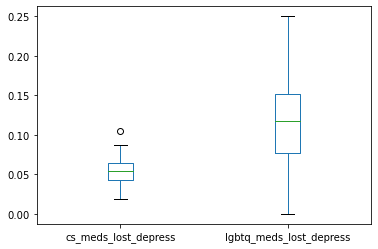

In [50]:
meds_lost_depress_plot_frame = variable_compare_LGBTQ("V1186 == '1' and V1203 == '2' and V1202 == '1'", 'meds_lost_depress')

In [51]:
prime_plot_frame_2 = prime_plot_frame.join(mh_plot_frame, how='left').join(meds_lost_plot_frame).join(pro_help_lost_plot_frame).join(diag_depress_plot_frame)

<AxesSubplot:xlabel='orr', ylabel='lgbtq_worthlessness'>

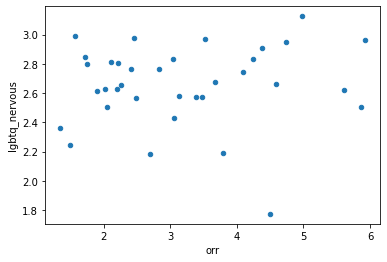

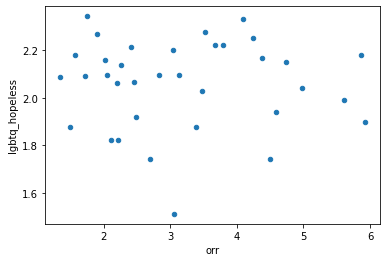

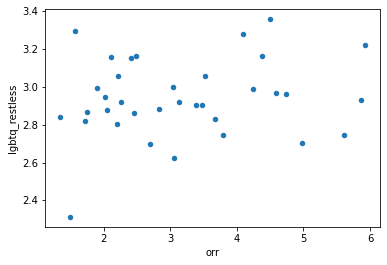

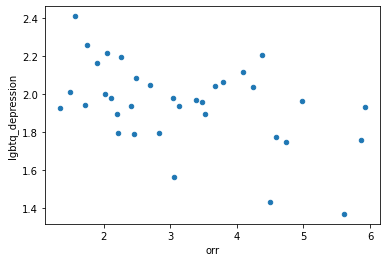

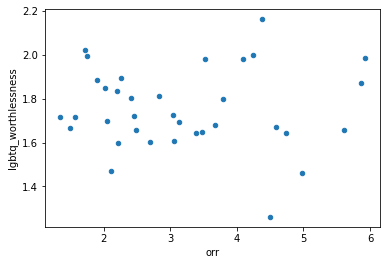

In [52]:
''' ORR seems to have a vaguely negative impact on mh measures; peer help? '''
prime_plot_frame_2.plot.scatter(x='orr', y='lgbtq_nervous')
prime_plot_frame_2.plot.scatter(x='orr', y='lgbtq_hopeless')
prime_plot_frame_2.plot.scatter(x='orr', y='lgbtq_restless')
prime_plot_frame_2.plot.scatter(x='orr', y='lgbtq_depression')
prime_plot_frame_2.plot.scatter(x='orr', y='lgbtq_worthlessness')

<AxesSubplot:xlabel='cs_worthlessness', ylabel='lgbtq_worthlessness'>

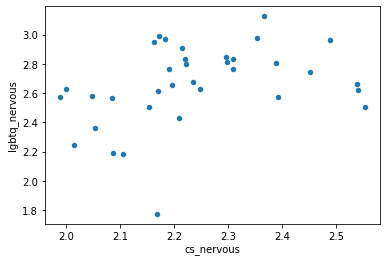

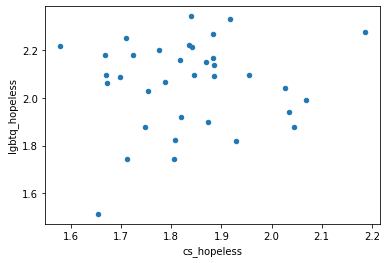

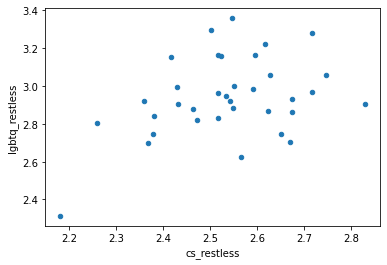

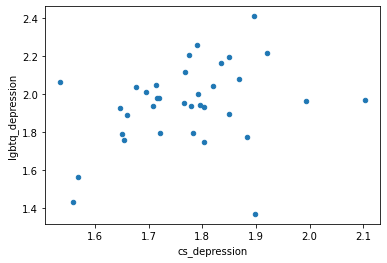

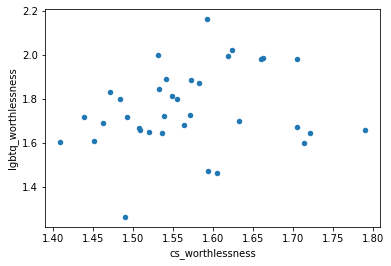

In [53]:
''' LGBTQ mh measures and cs mental health measures do not seem to trend together. '''
prime_plot_frame_2.plot.scatter(x='cs_nervous', y='lgbtq_nervous')
prime_plot_frame_2.plot.scatter(x='cs_hopeless', y='lgbtq_hopeless')
prime_plot_frame_2.plot.scatter(x='cs_restless', y='lgbtq_restless')
prime_plot_frame_2.plot.scatter(x='cs_depression', y='lgbtq_depression')
prime_plot_frame_2.plot.scatter(x='cs_worthlessness', y='lgbtq_worthlessness')

<AxesSubplot:xlabel='lgbtq_meds_lost', ylabel='lgbtq_pro_help_lost'>

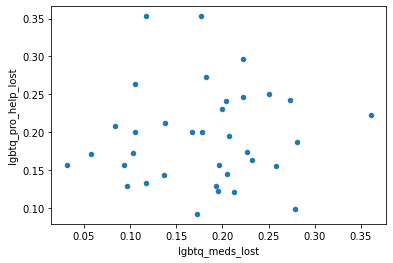

In [54]:
prime_plot_frame_2.plot.scatter(x='lgbtq_meds_lost', y='lgbtq_pro_help_lost')

<AxesSubplot:xlabel='orr', ylabel='lgbtq_diag_depress'>

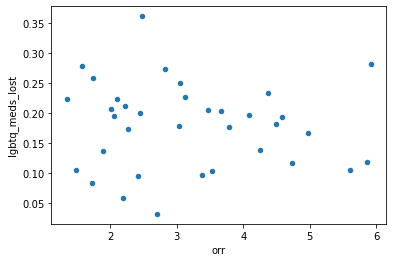

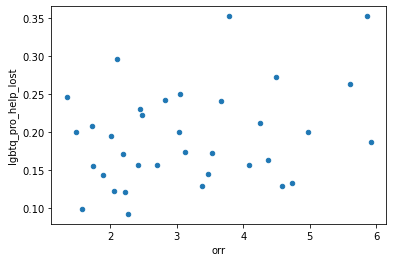

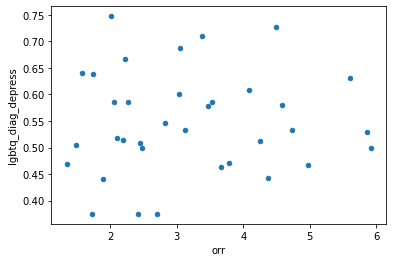

In [55]:
prime_plot_frame_2.plot.scatter(x='orr', y='lgbtq_meds_lost')
prime_plot_frame_2.plot.scatter(x='orr', y='lgbtq_pro_help_lost')
prime_plot_frame_2.plot.scatter(x='orr', y='lgbtq_diag_depress')

<AxesSubplot:xlabel='lgbtq_pro_help_lost', ylabel='lgbtq_worthlessness'>

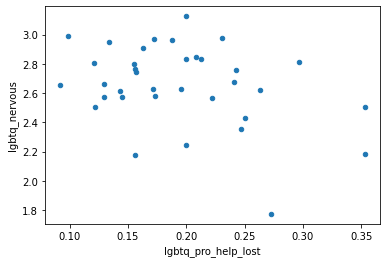

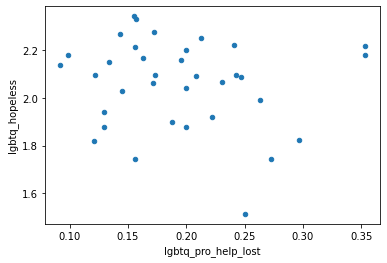

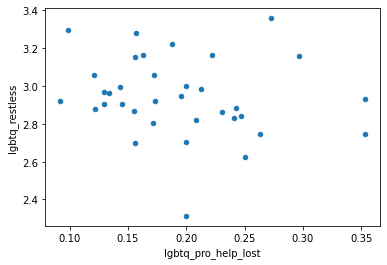

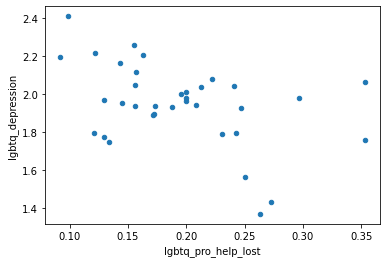

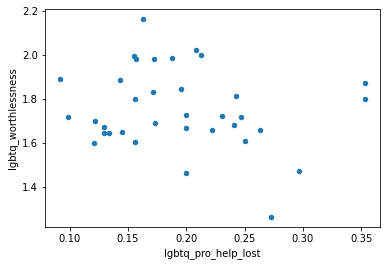

In [56]:
prime_plot_frame_2.plot.scatter(x='lgbtq_pro_help_lost', y='lgbtq_nervous')
prime_plot_frame_2.plot.scatter(x='lgbtq_pro_help_lost', y='lgbtq_hopeless')
prime_plot_frame_2.plot.scatter(x='lgbtq_pro_help_lost', y='lgbtq_restless')
prime_plot_frame_2.plot.scatter(x='lgbtq_pro_help_lost', y='lgbtq_depression')
prime_plot_frame_2.plot.scatter(x='lgbtq_pro_help_lost', y='lgbtq_worthlessness')

<AxesSubplot:xlabel='lgbtq_meds_lost', ylabel='lgbtq_worthlessness'>

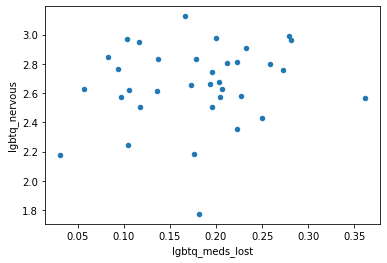

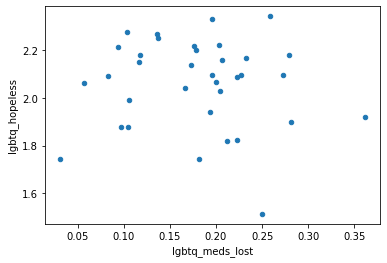

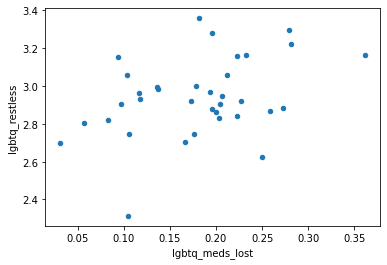

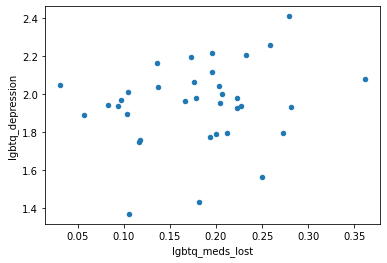

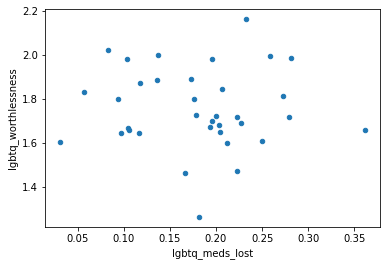

In [57]:
prime_plot_frame_2.plot.scatter(x='lgbtq_meds_lost', y='lgbtq_nervous')
prime_plot_frame_2.plot.scatter(x='lgbtq_meds_lost', y='lgbtq_hopeless')
prime_plot_frame_2.plot.scatter(x='lgbtq_meds_lost', y='lgbtq_restless')
prime_plot_frame_2.plot.scatter(x='lgbtq_meds_lost', y='lgbtq_depression')
prime_plot_frame_2.plot.scatter(x='lgbtq_meds_lost', y='lgbtq_worthlessness')

<AxesSubplot:xlabel='cs_diag_depress', ylabel='cs_meds_lost'>

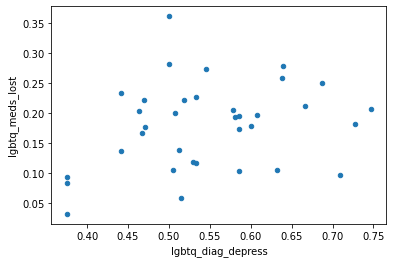

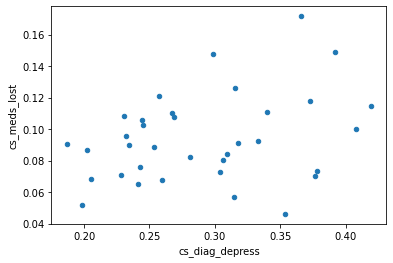

In [58]:
prime_plot_frame_2.plot.scatter(x='lgbtq_diag_depress', y='lgbtq_meds_lost')
prime_plot_frame_2.plot.scatter(x='cs_diag_depress', y='cs_meds_lost')


I'd like to take a look at prison regulatory treatment next.

In [99]:
def mean_compare_LGBTQ(var_name, trait_name, numeric=False):
    acc_vars_bs = {}
    for state in list_state_codes:
        q = 0
        if(not numeric):
            Q = remove_indet(lgbtq_bs[state], var_name)
        else:
            Q = lgbtq_bs[state]
        for p in Q[var_name]:
            try:
                q += int(p)
            except ValueError:
                pass
        if q != 0:
            q /= len(Q)
        
        c = 0
        if(not numeric):
            C = remove_indet(cs_bs[state], var_name)
        else:
            C = cs_bs[state]
        for p in C[var_name]:
            try:
                c += int(p)
            except ValueError:
                pass
        
        if c != 0 and q != 0:
            c /= len(C)
            acc_vars_bs[state] = [c, q, q/c]

    return pandas.DataFrame.from_dict(acc_vars_bs, orient='index', columns = [f'cs_{trait_name}', f'lgbtq_{trait_name}', f'{trait_name}r'])

In [100]:
''' Quick aside about age. '''
age_plot_frame = mean_compare_LGBTQ("RV0001", "mean_age", numeric=True)

<AxesSubplot:>

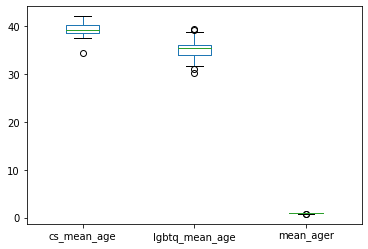

In [106]:
age_plot_frame.plot.box()

<AxesSubplot:>

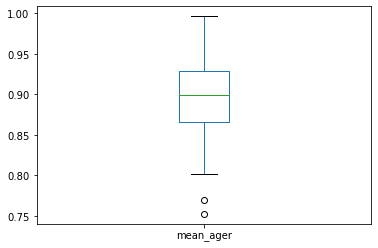

In [104]:
''' LGBTQ incarcerated people are skew slightly younger than cs group. '''
age_plot_frame['mean_ager'].plot.box()

In [60]:
'''
Take the mean number of violations per group per state to make the WUR (Write-Up Rate). This might be inefficient. 
Then, use each WUR to make the WURR (Write-Up Rate Ratio).
'''

wur_plot_frame = mean_compare_LGBTQ('V1397', 'wur')

<AxesSubplot:>

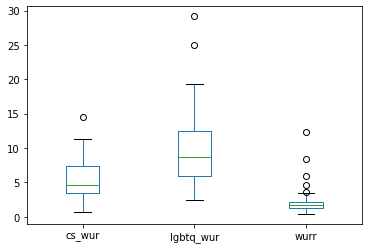

In [61]:
wur_plot_frame.plot.box()

<AxesSubplot:>

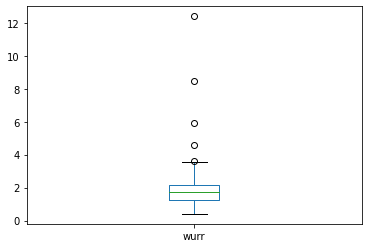

In [62]:
wur_plot_frame['wurr'].plot.box()

In [63]:
print(wur_plot_frame.mean())
print()
print(wur_plot_frame.median())

cs_wur        5.432745
lgbtq_wur    10.116172
wurr          2.415073
dtype: float64

cs_wur       4.685250
lgbtq_wur    8.677419
wurr         1.710843
dtype: float64


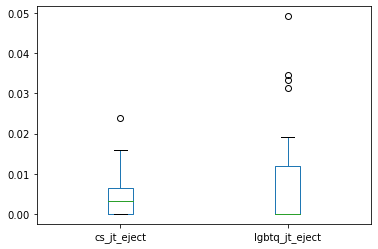

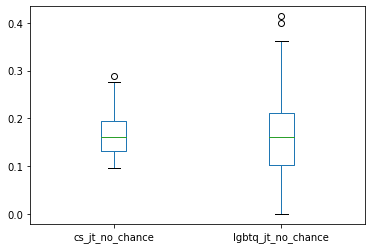

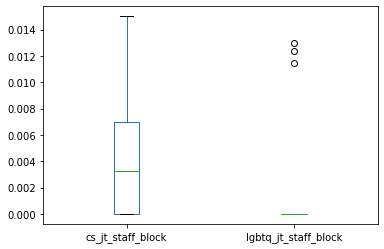

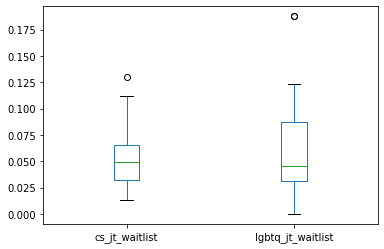

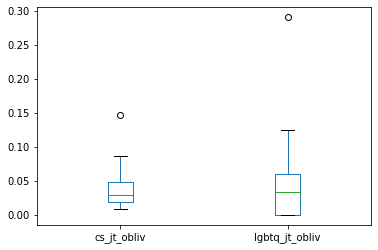

In [64]:
''' 
LGBTQ inmates seem to fair a little worse at job training security.
'''

jt_eject_plot_frame = variable_compare_LGBTQ('V1471 == 4', 'jt_eject')
jt_no_chance_plot_frame = variable_compare_LGBTQ('V1478 == "3"', 'jt_no_chance')
jt_staff_block_plot_frame = variable_compare_LGBTQ('V1478 == "5"', 'jt_staff_block')
jt_waitlist_plot_frame = variable_compare_LGBTQ('V1478 == "8"', 'jt_waitlist')
jt_obliv_plot_frame = variable_compare_LGBTQ('V1478 == "1"', 'jt_obliv')

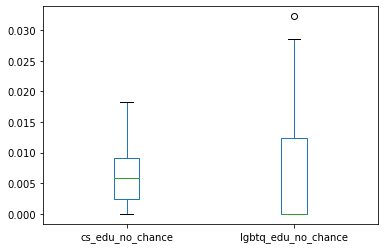

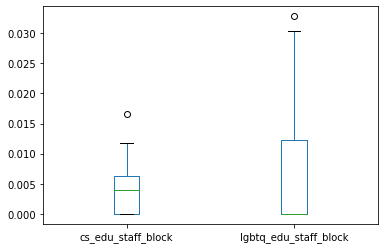

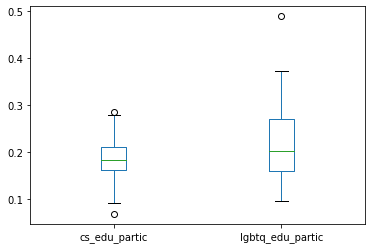

In [65]:
''' 
LGBTQ inmates have a somewhat harder time entering educational programs in at least some states, 
but participate in them at a higher rate when allowed.
'''
edu_no_chance_plot_frame = variable_compare_LGBTQ('V1493 == 3', 'edu_no_chance')
edu_staff_block_plot_frame = variable_compare_LGBTQ('V1495 == 5', 'edu_staff_block')
edu_partic_plot_frame = variable_compare_LGBTQ('V1490 == "1"', 'edu_partic')

In [66]:
prime_plot_frame_3 = prime_plot_frame_2.join(wur_plot_frame)

<AxesSubplot:xlabel='orr', ylabel='wurr'>

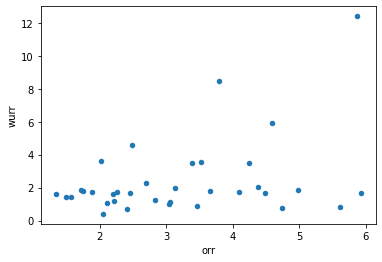

In [67]:
prime_plot_frame_3.plot.scatter(x='orr', y='wurr')

<AxesSubplot:xlabel='wurr', ylabel='lgbtq_worthlessness'>

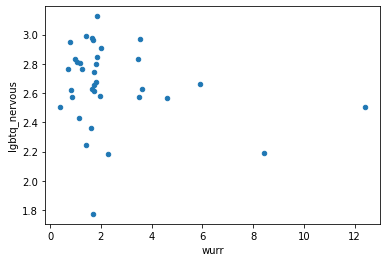

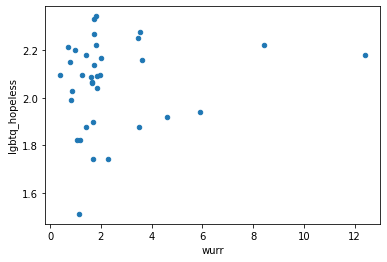

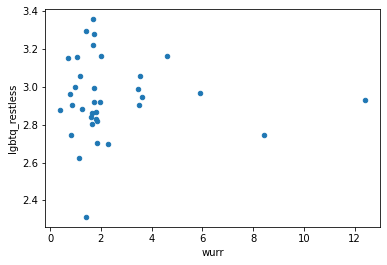

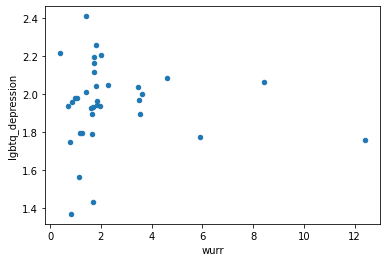

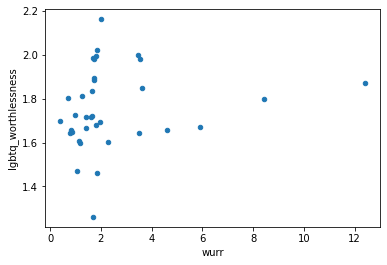

In [68]:
prime_plot_frame_3.plot.scatter(x='wurr', y='lgbtq_nervous')
prime_plot_frame_3.plot.scatter(x='wurr', y='lgbtq_hopeless')
prime_plot_frame_3.plot.scatter(x='wurr', y='lgbtq_restless')
prime_plot_frame_3.plot.scatter(x='wurr', y='lgbtq_depression')
prime_plot_frame_3.plot.scatter(x='wurr', y='lgbtq_worthlessness')

Now we'll finish this section by looking at sentencing.

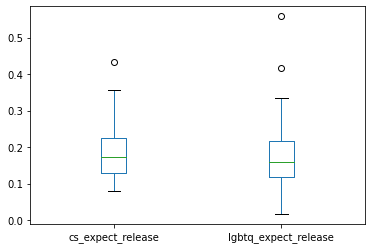

In [69]:
expected_release_plot_frame = variable_compare_LGBTQ("V0473 == '1'", 'expect_release')

<AxesSubplot:>

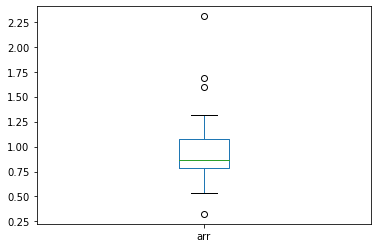

In [70]:
''' 
LGBTQ inmates in our sample actually have generally fewer total arrests in their lifetime 
than the cs inmates in most states.
'''
arr_plot_frame = mean_compare_LGBTQ("V0909", 'ar')
arr_plot_frame['arr'].plot.box()

<AxesSubplot:>

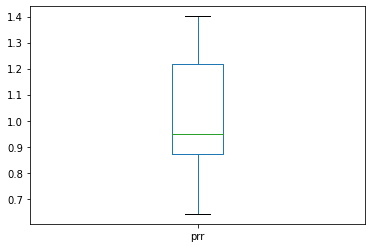

In [71]:
''' 
They also report a similar number of total probations.
'''
prr_plot_frame = mean_compare_LGBTQ("V0910", 'pr')
prr_plot_frame['prr'].plot.box()

<AxesSubplot:>

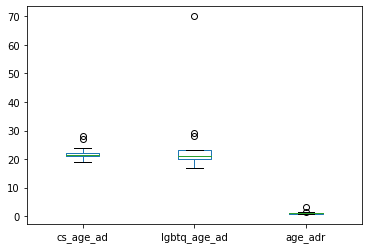

In [72]:
age_admit_plot_frame = mean_compare_LGBTQ('V0918', 'age_ad')
age_admit_plot_frame.plot.box()

cs_age_ad       22.220434
lgbtq_age_ad    25.230769
age_adr          1.154611
dtype: float64

cs_age_ad       21.500000
lgbtq_age_ad    21.000000
age_adr          0.930233
dtype: float64


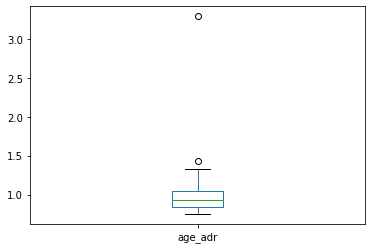

In [73]:
age_admit_plot_frame['age_adr'].plot.box()
print(age_admit_plot_frame.mean())
print()
print(age_admit_plot_frame.median())

# COMPARISON

In [74]:
state_pops = pandas.read_csv("pop_counts\state_pops.csv")
pops_bs = {}
for state in list_state_codes:
    pops_bs[state] = int(state_pops.query(f'Label == "{state}"')['Total'])
state_pop_plot_frame = pandas.DataFrame.from_dict(pops_bs, orient='index', columns = ['state_pop'])

In [75]:
incs_bs = {}
for state in list_state_codes:
    I = int(state_incs.query(f'State == "{state}"')['Incarcerated'])
    incs_bs[state] = [I, I/pops_bs[state]]
state_inc_plot_frame = pandas.DataFrame.from_dict(incs_bs, orient='index', columns = ['state_inc', 'ir'])

In [76]:
state_trans = pandas.read_csv(r"pop_counts\trans_by_state.csv")
trans_bs = {}
for state in list_state_codes:
    trans_bs[state] = float(state_trans.query(f'State == "{state}"')['Proportion'])
trans_prop_plot_frame = pandas.DataFrame.from_dict(trans_bs, orient='index', columns = ['trans_prop'])

In [77]:
state_2016_elect = pandas.read_csv(r"external\2016_election.csv")
elect_perc_bs = {}
for state in list_state_codes:
    elect_perc_bs[state] = [float(state_2016_elect.query(f'Label == "{state}"')['percD']), float(state_2016_elect.query(f'Label == "{state}"')['percR'])]
elect_perc_plot_frame = pandas.DataFrame.from_dict(elect_perc_bs, orient='index', columns = ['perc_elect_dem', 'perc_elect_rep'])

In [78]:
poverty_data = pandas.read_csv(r"external\state_poverty.csv")
poverty_bs = {}
for state in list_state_codes:
    below_pov_perc = float(poverty_data.query(f"Label == '{state}'")["Percent below poverty level!!Estimate!!Population for whom poverty status is determined"]) / 100
    fem_bpp = float(poverty_data.query(f"Label == '{state}'")["Percent below poverty level!!Estimate!!UNRELATED INDIVIDUALS FOR WHOM POVERTY STATUS IS DETERMINED!!Female"]) / 100
    poverty_bs[state] = [below_pov_perc, fem_bpp]
poverty_plot_frame = pandas.DataFrame.from_dict(poverty_bs, orient='index', columns = ['state_below_pov', 'fem_below_pov'])

In [79]:
'''
True Prime Plot Frame Variables:
(* indicates that variable is from external data)

orr - OverRepresentation Ratio
aaorr - African American OverRepresentation Ratio
nworr - Non White OverRepresentation Ratio
fem_prop - Female Proportion
lgbtq_fem_prop - LGBTQ Female Proportion
lgbtq_depression - LGBTQ Depression mean from 1 to 5
wurr - WriteUp Rate Ratio
arr - Arrest Rate Ratio
prr - Probation Rate Ratio
rratio - Response Ratio
ir* - Incarceration Rate
state_lgbtq* - Estimated proportion of state which is LGBTQ
incar_lgbtq* - Estimated proportion of people incarcerated in state who are LGBTQ
state_pop* - State Population
perc_elect_rep* - Percent of state that voted Republican in 2016 election
perc_elect_dem* - Percent of state that voted Democrat in 2016 election
state_below_pov* - Percent of state below poverty line in 2016
'''

true_prime_plot_frame = prime_plot_frame_3.join(state_pop_plot_frame).join(state_inc_plot_frame).join(trans_prop_plot_frame).join(elect_perc_plot_frame).join(arr_plot_frame).join(prr_plot_frame).join(age_admit_plot_frame).join(poverty_plot_frame)

In [80]:
def compare_scatters(var_name):
    ''' Use the true_prime_plot_frame to make a batch of scatter plots with var_name as the x axis. '''
    true_prime_plot_frame.plot.scatter(x=var_name, y='orr', c='black')
    true_prime_plot_frame.plot.scatter(x=var_name, y='aaorr', c='black')
    true_prime_plot_frame.plot.scatter(x=var_name, y='nworr', c='black')
    true_prime_plot_frame.plot.scatter(x=var_name, y='lgbtq_depression', c='black')
    true_prime_plot_frame.plot.scatter(x=var_name, y='wurr', c='black')
    true_prime_plot_frame.plot.scatter(x=var_name, y='arr', c='black')
    true_prime_plot_frame.plot.scatter(x=var_name, y='prr', c='black')
    true_prime_plot_frame.plot.scatter(x=var_name, y='rratio', c='black')

Each of these scatters will be a variable not collected by the SoPI vs one that I've derived from it.

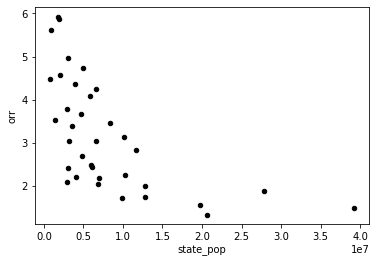

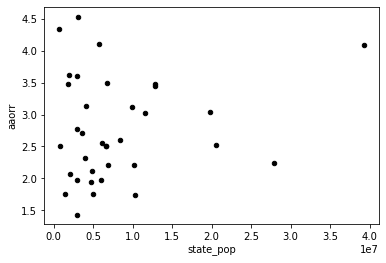

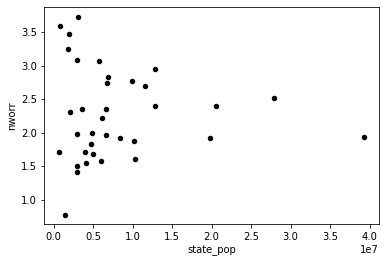

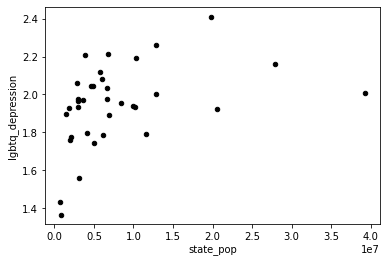

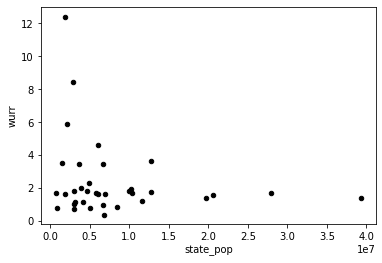

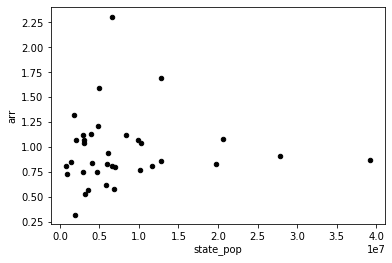

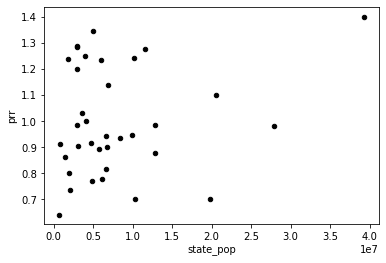

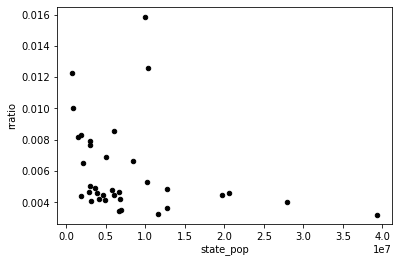

In [81]:
compare_scatters('state_pop')

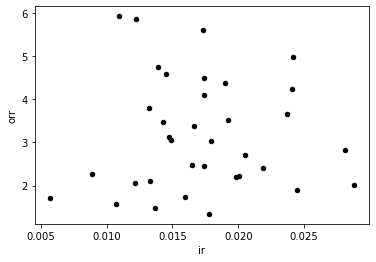

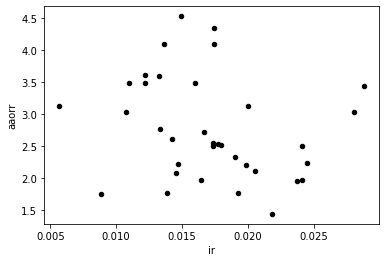

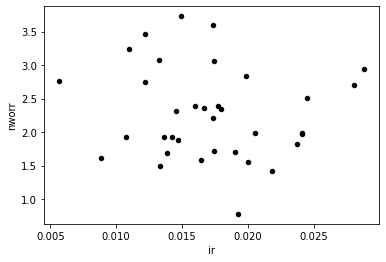

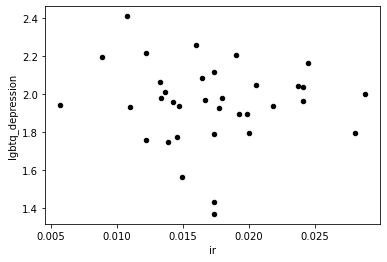

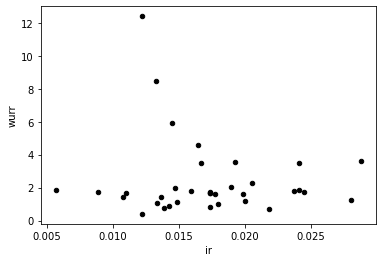

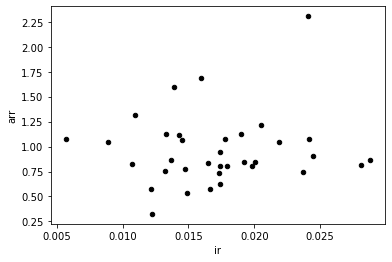

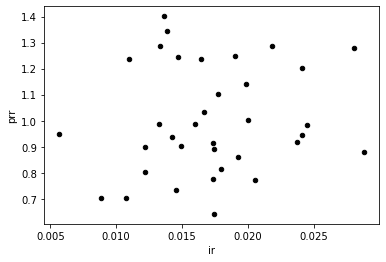

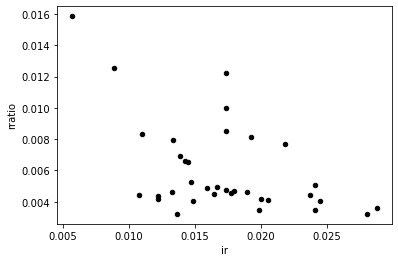

In [82]:
compare_scatters('ir')

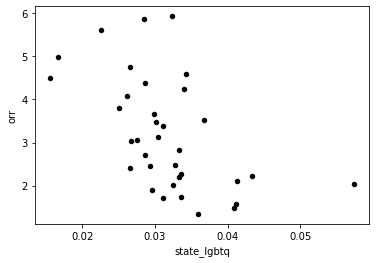

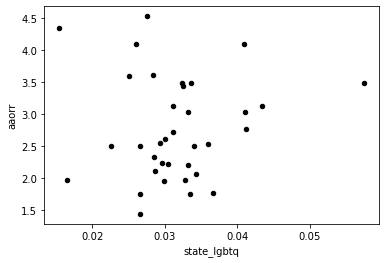

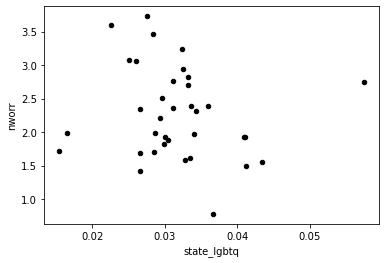

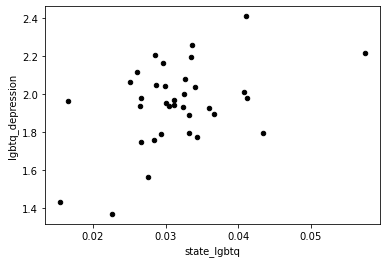

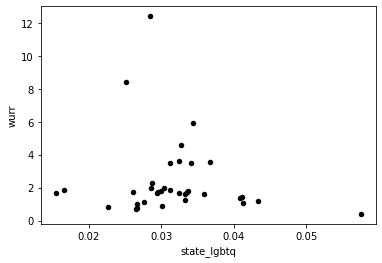

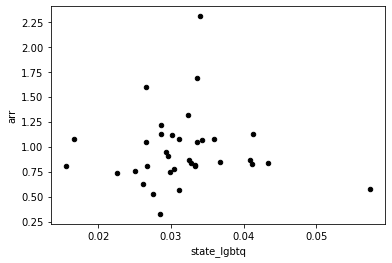

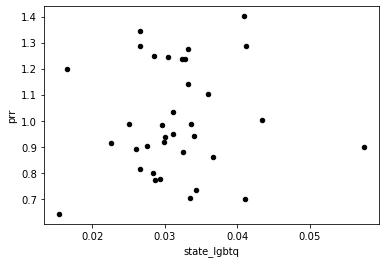

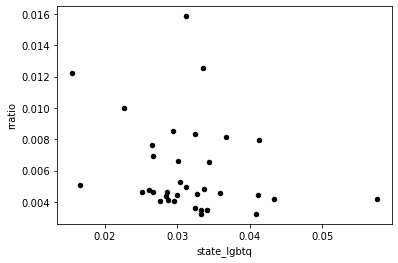

In [83]:
compare_scatters('state_lgbtq')

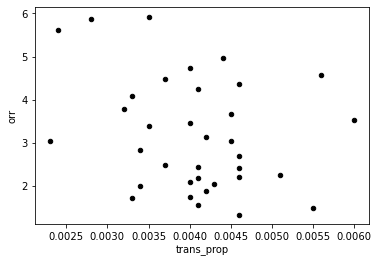

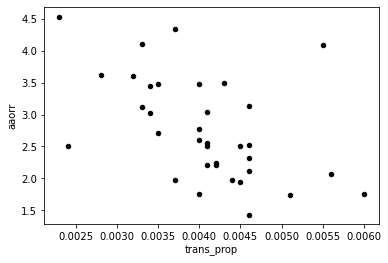

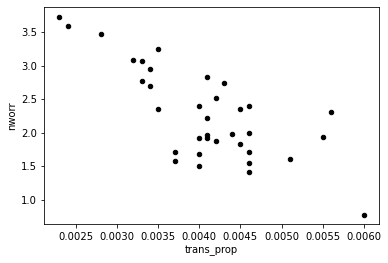

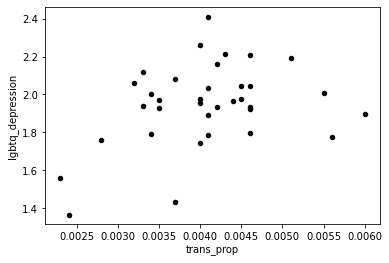

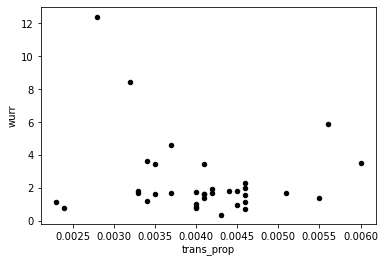

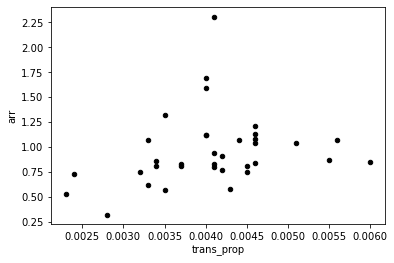

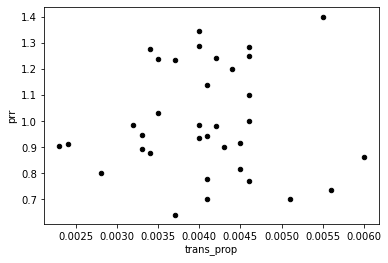

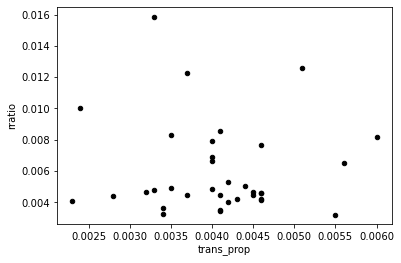

In [84]:
compare_scatters('trans_prop')

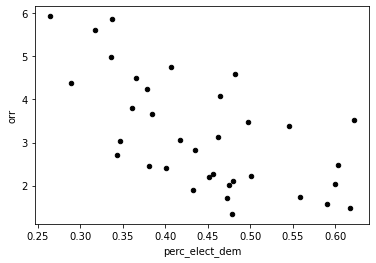

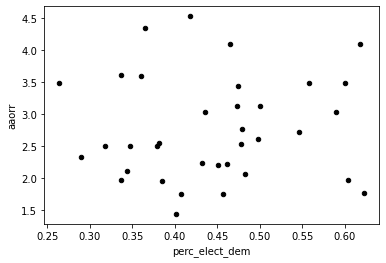

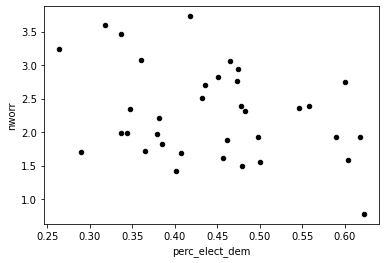

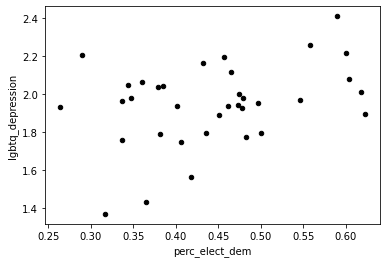

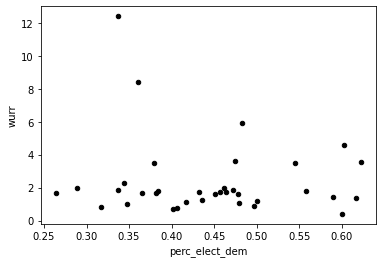

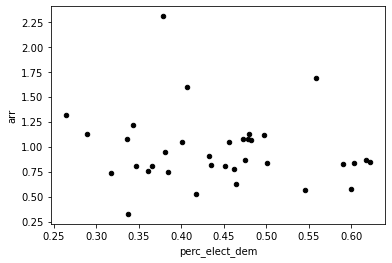

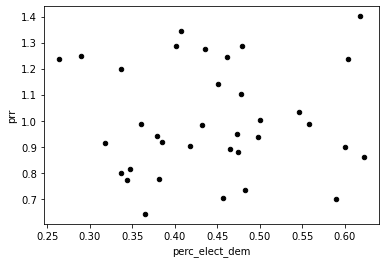

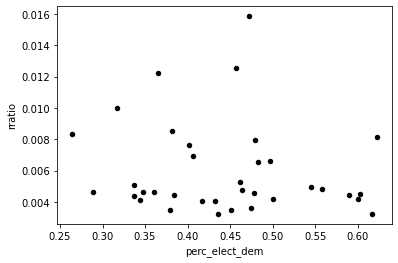

In [85]:
''' ORR trends negatively with the percent of the state that voted Democrat in the 2016 presidential election. '''
''' Likewise, ignoring outlier values, ARR trends negatively with the same.'''
''' WURR has the opposite behavior, with a (very mild) positive trend, ignoring outliers. '''

compare_scatters('perc_elect_dem')

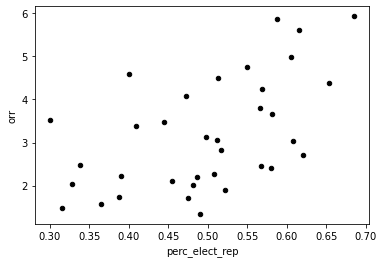

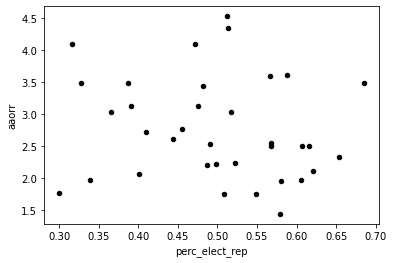

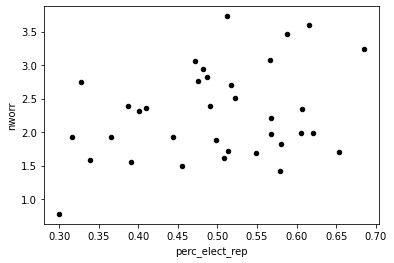

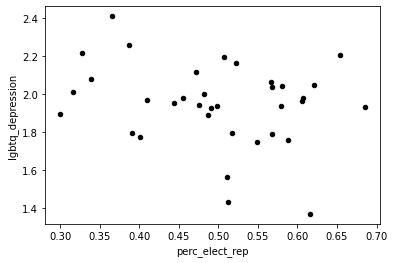

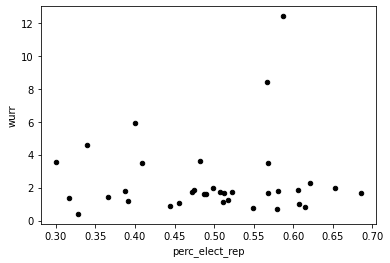

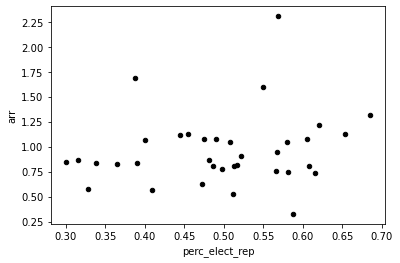

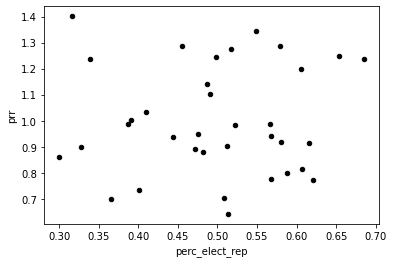

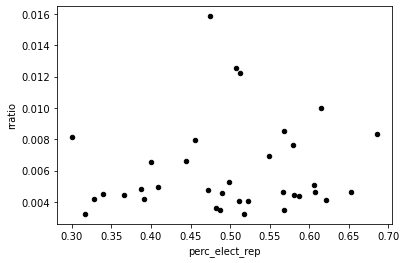

In [86]:
''' ORR trends positively with the percent of the state that voted Republican in the 2016 presidential election. '''
''' Likewise, ignoring outlier values, ARR trends positively with the same, granted at a much lower slope.'''
''' WURR has the opposite behavior, with a (very mild) negative trend, ignoring outliers. '''
compare_scatters('perc_elect_rep')

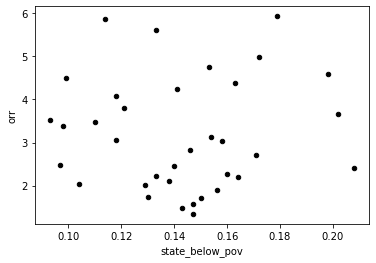

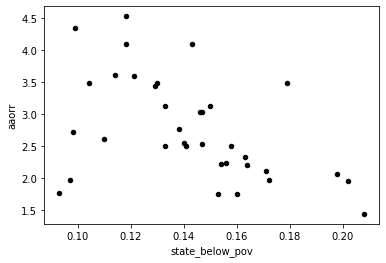

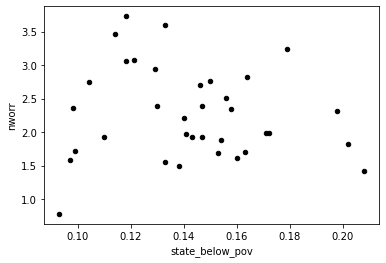

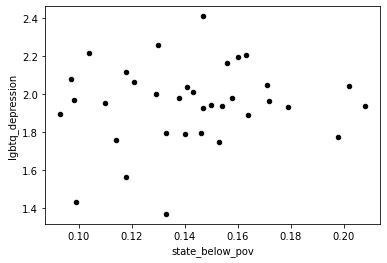

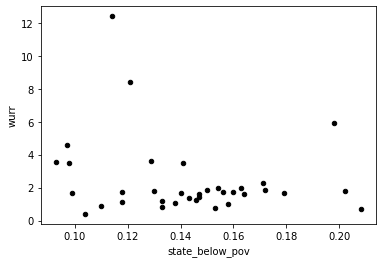

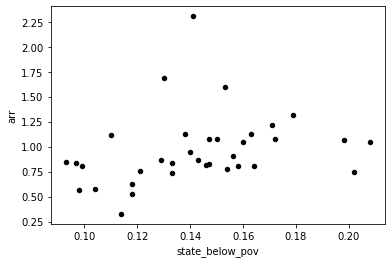

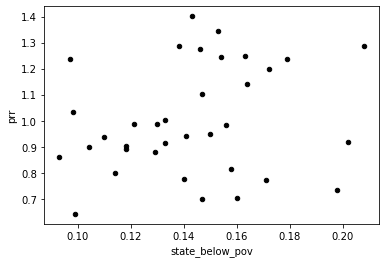

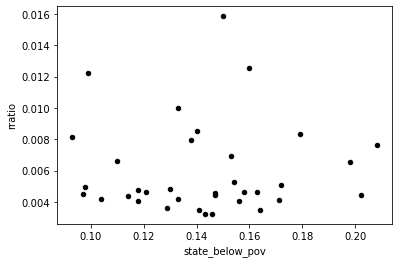

In [87]:
''' 
AAORR seems to trend ngatively with state_below_pov.
WURR might do the same minus outliers but it's hard to tell.

Meanwhile, ARR trends positively with it.
'''

compare_scatters('state_below_pov')

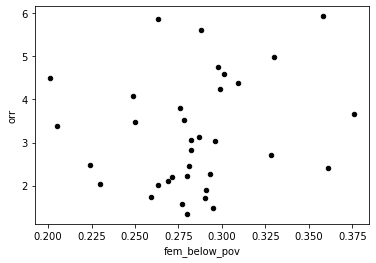

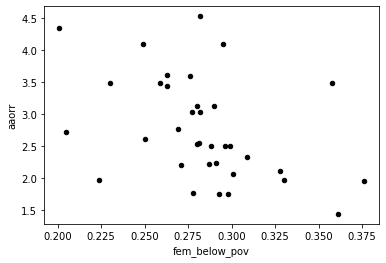

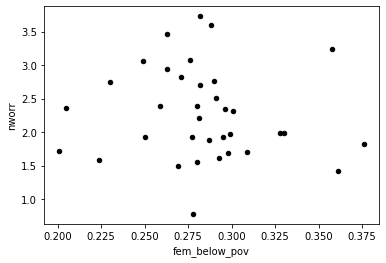

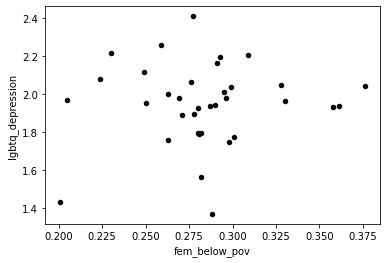

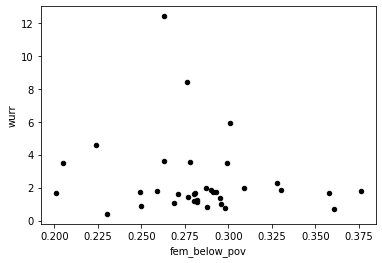

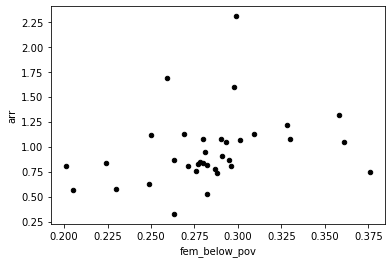

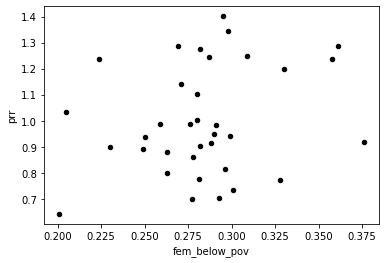

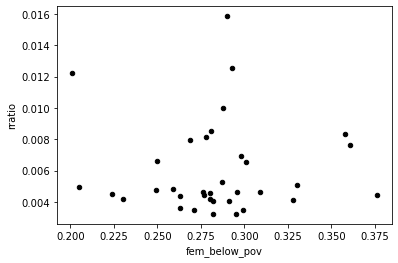

In [88]:
compare_scatters('fem_below_pov')

In [89]:
def compare_scatters_mh(var_name):
    ''' Use the true_prime_plot_frame to make a batch of scatter plots with var_name as the x axis. '''
    true_prime_plot_frame.plot.scatter(x=var_name, y='lgbtq_nervous', c='black')
    true_prime_plot_frame.plot.scatter(x=var_name, y='lgbtq_hopeless', c='black')
    true_prime_plot_frame.plot.scatter(x=var_name, y='lgbtq_restless', c='black')
    true_prime_plot_frame.plot.scatter(x=var_name, y='lgbtq_depression', c='black')
    true_prime_plot_frame.plot.scatter(x=var_name, y='lgbtq_worthlessness', c='black')
    true_prime_plot_frame.plot.scatter(x=var_name, y='cs_nervous', c='black')
    true_prime_plot_frame.plot.scatter(x=var_name, y='cs_hopeless', c='black')
    true_prime_plot_frame.plot.scatter(x=var_name, y='cs_restless', c='black')
    true_prime_plot_frame.plot.scatter(x=var_name, y='cs_depression', c='black')
    true_prime_plot_frame.plot.scatter(x=var_name, y='cs_worthlessness', c='black')

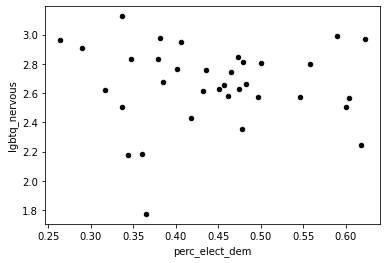

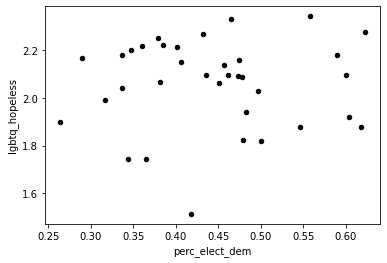

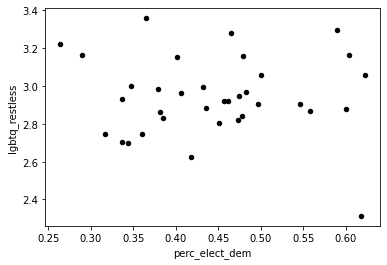

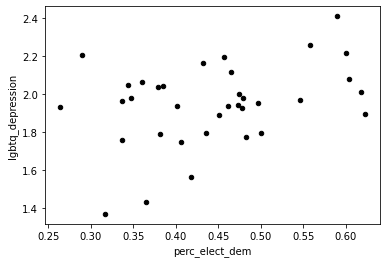

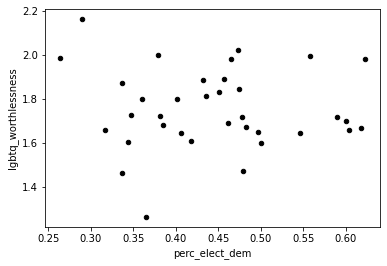

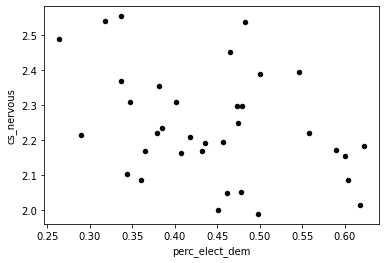

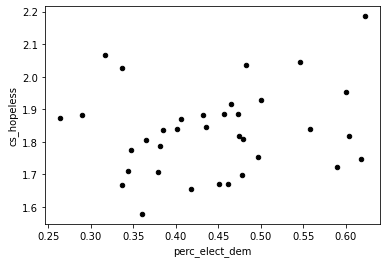

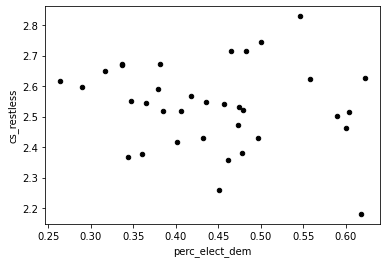

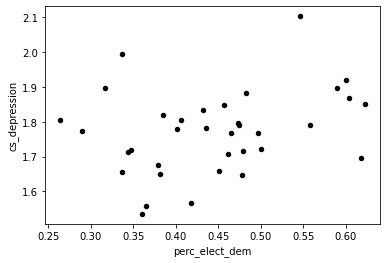

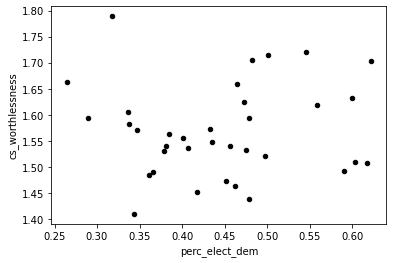

In [90]:
compare_scatters_mh('perc_elect_dem')

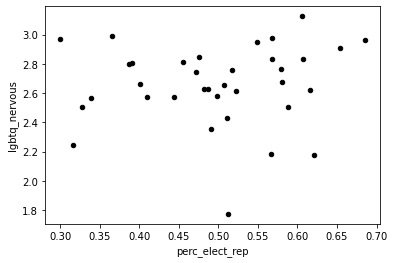

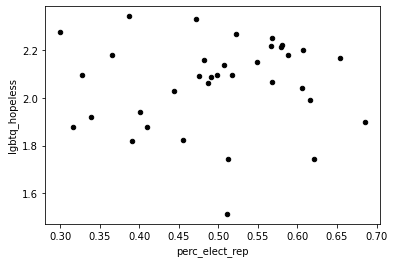

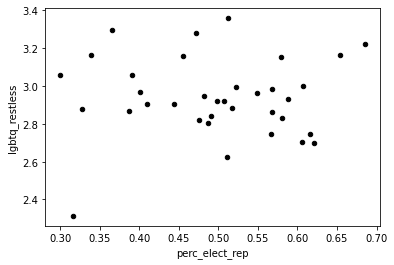

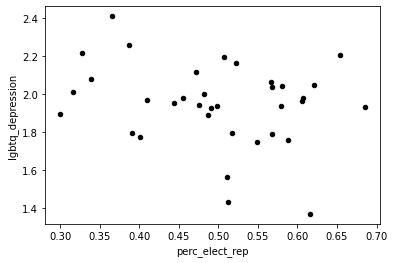

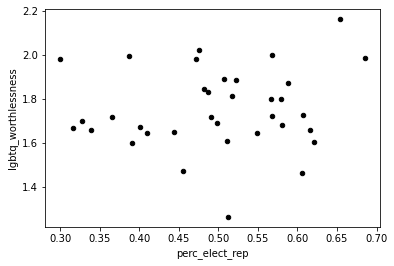

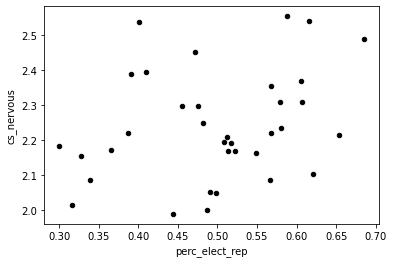

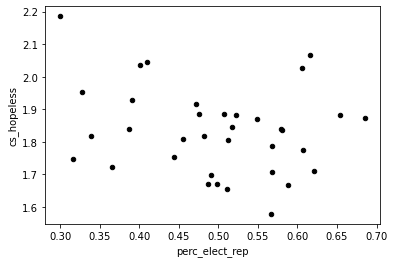

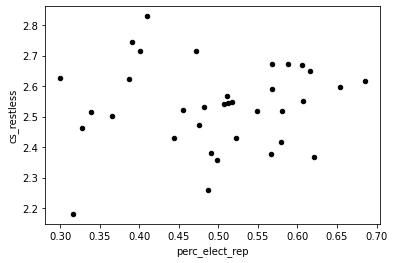

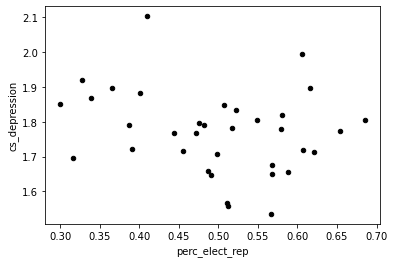

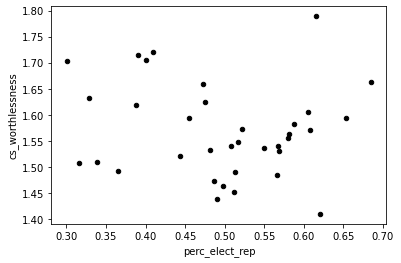

In [91]:
compare_scatters_mh('perc_elect_rep')

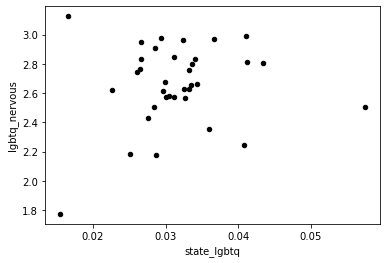

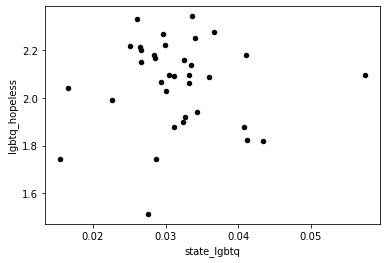

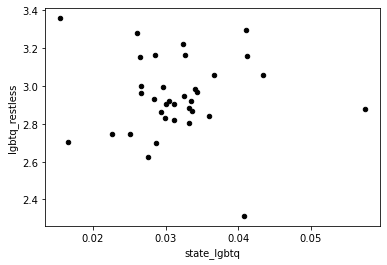

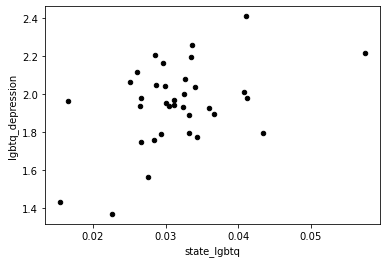

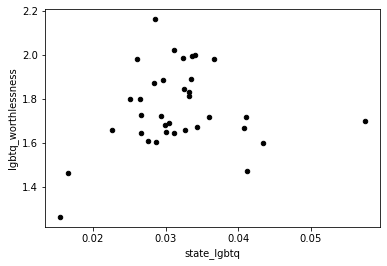

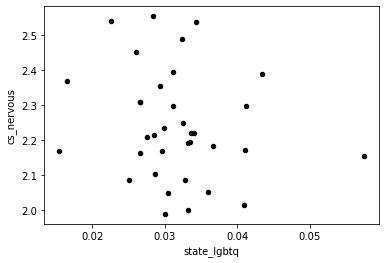

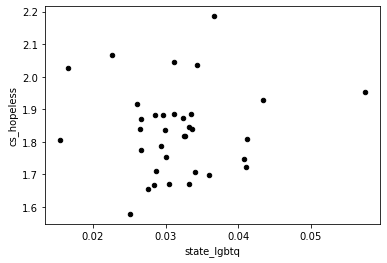

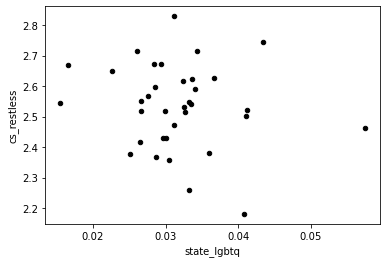

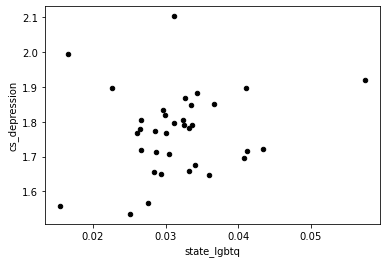

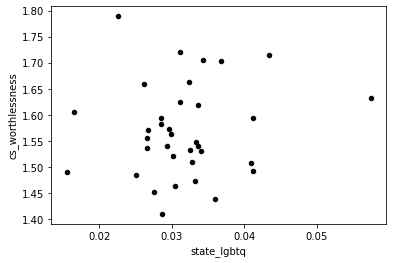

In [92]:
compare_scatters_mh('state_lgbtq')

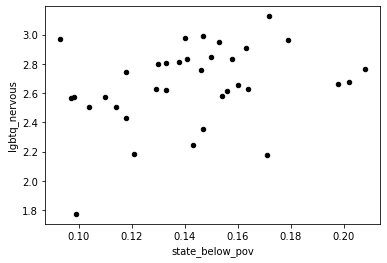

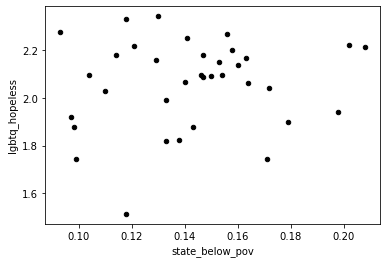

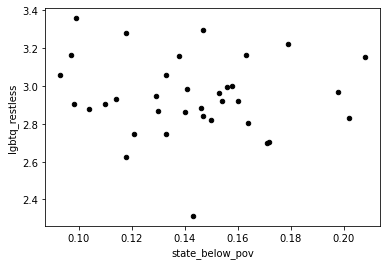

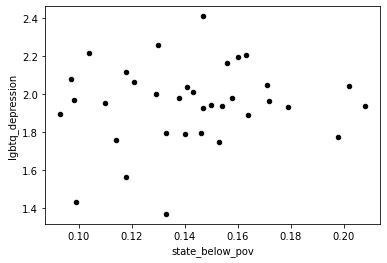

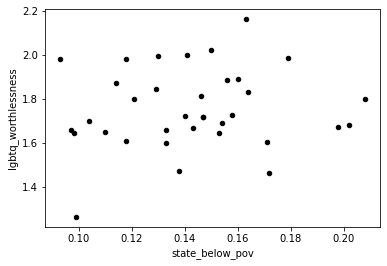

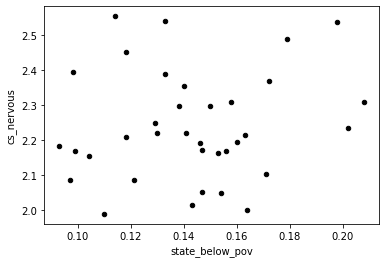

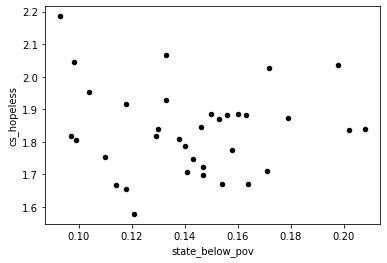

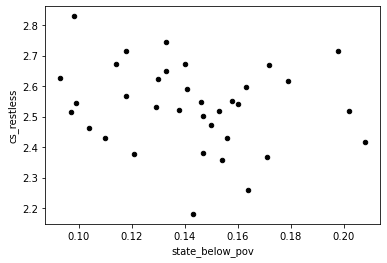

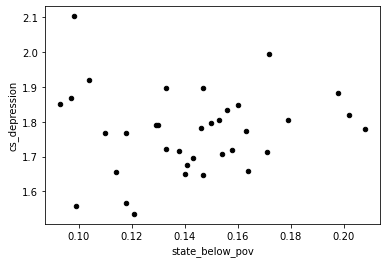

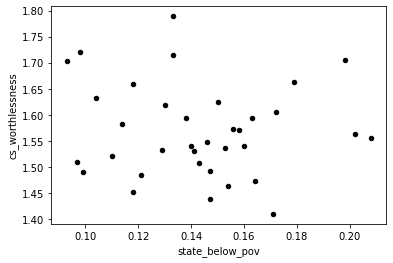

In [93]:
''' LGBTQ nervousness seems to have a positive trend with state pop. below poverty line,
but most measures are inconclusive.'''
compare_scatters_mh('state_below_pov')

TODO LIST
- (idea!) Compare time series for a state (TX?)
